In [140]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 10 17:37:31 2018

Titanic Competition in Kaggle
Dataset path : E:\Data_and_Script\Python_Script\titanic\train.csv'
Data from : Kaggle.com

Python 3.6.3 
GUI : Spyder from Anaconda 5.0.1
OS : windows 10 v1709 64 bit

P1 : EDA
P2 : Feature Engineering
P3 : Model and Ensemble

@author: Haby
"""
# 1.1 import Package
# general packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# ML packages
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# Model Tune packages
from sklearn.model_selection import GridSearchCV

# CV Folder 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

# Stacking Model
import xgboost as xgb

In [141]:
# 1.2 import data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
c = [train,test]
PassengerId = test['PassergerId']

# 1.3 check NAs
print(train.isnull().sum())
print(test.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


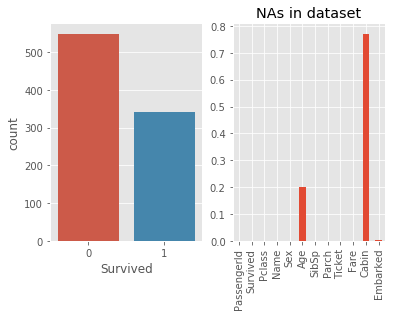

In [142]:
# 2.1 Basic Visualation of Survived and NAs
_,ax = plt.subplots(1,2)
sns.countplot(train.Survived,ax = ax[0])
(train.isnull().sum()/len(train)).plot(ax =ax[1],kind = 'bar',
    title = 'NAs in dataset')
# More ppl died than survived, for dataset, more than 75% of Cabin is NA and 
# 20% of Age is NA and few NAs in Embarked

In [ ]:
# 2.2 Find the important features

# 2.2.1 All numeric Values
sns.heatmap(train.corr(),annot=True)
# Pclass and Fare are seems important

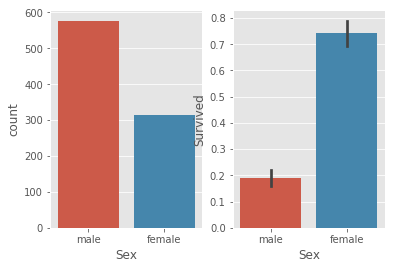

In [143]:
# 2.2.2 Sex
_,ax = plt.subplots(1,2)
sns.countplot(train.Sex,ax =ax[0])
sns.barplot(x = train.Sex,y = train.Survived,ax =ax[1])
# Survived rate is apparently changed for different sex
# str to numeric
for data in c :
    data['Sex'] = data['Sex'].replace(['male','female'],[0,1])

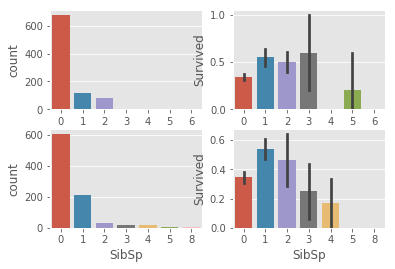

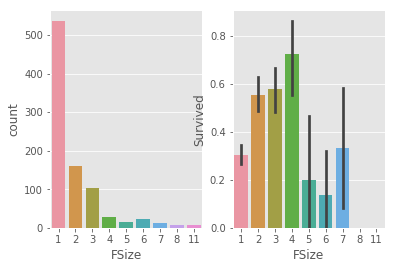

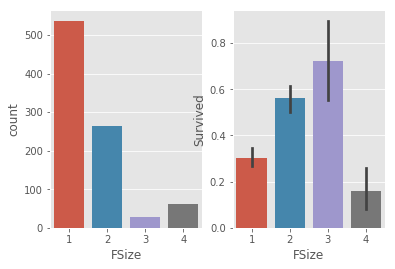

In [144]:
# 2.2.3 Parch and SibSp
_,ax = plt.subplots(2,2)
sns.countplot(train.Parch,ax =ax[0,0])
sns.barplot(x = train.Parch,y = train.Survived,ax =ax[0,1])
sns.countplot(train.SibSp,ax =ax[1,0])
sns.barplot(x = train.SibSp,y = train.Survived,ax =ax[1,1])
# two variable are strongly related, considering combine to one variable

# FamilySize and IsAlone
for data in c :
    data['FSize'] = data['Parch'] + data['SibSp'] + 1
    
# plot
_,ax = plt.subplots(1,2)
sns.countplot(train.FSize,ax =ax[0])
sns.barplot(x = train.FSize,y = train.Survived,ax =ax[1])
# survived rate increased as fsize inscrease till fsize = 4

# group familysize : single , couple(/child), med family and large family
for data in c :
    data['FSize'] = data['FSize'].replace([1,2,3,4,5,6,7,8,11],[1,2,2,3,4,4,4,4,4])
# plot
_,ax = plt.subplots(1,2)
sns.countplot(train.FSize,ax =ax[0])
sns.barplot(x = train.FSize,y = train.Survived,ax =ax[1])

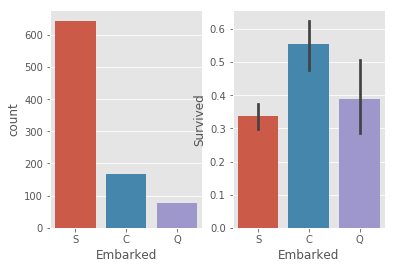

In [145]:
# 2.2.4 Embarked
_,ax = plt.subplots(1,2)
sns.countplot(train.Embarked,ax =ax[0])
sns.barplot(x = train.Embarked,y = train.Survived,ax =ax[1])
# Survived rate is apparently changed for different Embark
# fill na with Max value S
for data in c :
    data['Embarked'] = data.Embarked.fillna('S')
# str to numeric
for data in c :
    data['Embarked'] = data['Embarked'].replace(['S','Q','C'],[0,1,2])

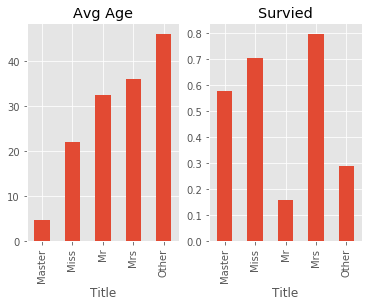

In [146]:
# 2.2.5 Title from Name
for data in c:
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# group title
for data in c :
    data['Title'] = data['Title'].replace(['Mme','Ms','Mlle','Lady','Dr','Rev','Col',
        'Major','Don','Mme','Countess','Sir','Jonkheer','Capt','Dona'],
        ['Mrs','Miss','Miss','Mrs','Other','Other','Other','Other','Other','Other',
         'Mrs','Other','Other','Other','Mrs'])
# check average age and survived rate
_,ax = plt.subplots(1,2)
train.groupby('Title')['Age'].mean().plot(kind = 'bar',ax = ax[0],title = 'Avg Age')
train.groupby('Title')['Survived'].mean().plot(kind = 'bar',ax = ax[1],title = 'Survied')
# str to numeric
for data in c :
    data['Title'] = data['Title'].replace(['Mr','Mrs','Miss','Master','Other'],
        [0,1,2,3,4])
# title may has a strong relationship with Age and Sex, may drop in Emsemble

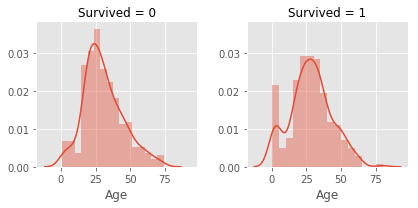

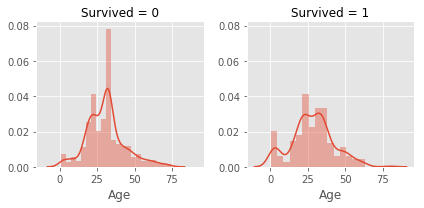

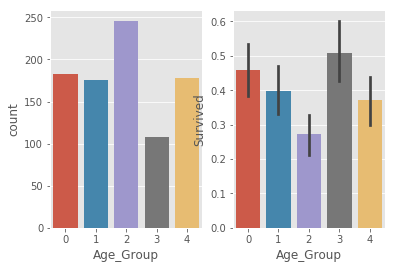

In [147]:
# 2.2.6 Age
# age is a skewed distribution with a large tail, I considered to scale the data
# at first , but I found groupize the age will be better choice
g = sns.FacetGrid(col = 'Survived',data = train)
g.map(sns.distplot,'Age')
# imputation Age with mean of different title
for data in c :
    data['Age'] = data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.mean()))
# plot again
g = sns.FacetGrid(col = 'Survived',data = train)
g.map(sns.distplot,'Age')
# range of age is 0-80, we groupize age with 5 groups
for data in c :
    data['Age_Group'] = pd.qcut(data['Age'],5,labels = [0,1,2,3,4]).astype(int)
# check count and survived rate
_,ax = plt.subplots(1,2)
sns.countplot(train.Age_Group,ax = ax[0])
sns.barplot(x = 'Age_Group', y = 'Survived',data = train,ax = ax[1])

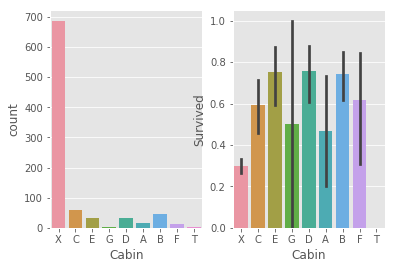

In [148]:
# 2.2.7 Cabin
# pickup the captial word of all cabin and fill na with x
for data in c :
    data['Cabin'] = data.Cabin.fillna('X')
    data['Cabin'] = data['Cabin'].map(lambda x : x[0])
# check count and survived rate
_,ax = plt.subplots(1,2)
sns.countplot(train.Cabin,ax = ax[0])
sns.barplot(x = 'Cabin', y = 'Survived',data = train,ax = ax[1])
# Cabin = x has largest value while lowest survived rate
# cabin = a,b,c,d,e,f,t are in Pclass 1, strong relationship with pclass
# cabin means location on Titanic, better place may has a better chance to
# survive only in first shock, if they are in water already, eveyone is same

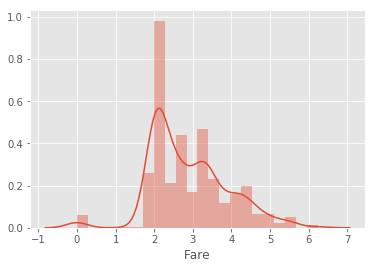

In [149]:
# 2.2.8 Scale the Fare
for data in c :
    data['Fare'] = data['Fare'].map(lambda x : np.log(x) if x != 0 else 0)
# fill na
test['Fare'] = test.groupby(['Pclass','Cabin'])['Fare'].transform(lambda x: x.fillna(x.mean()))

# plot 
sns.distplot(train.Fare)


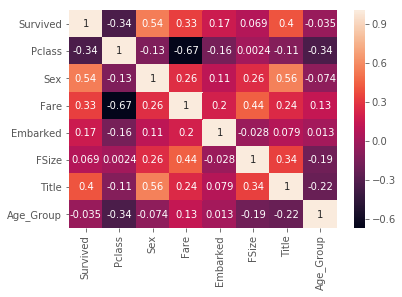

In [150]:
# 2.3 drop unneeded colunms :
drop_col = ['PassengerId','Name','Ticket','Age','SibSp','Parch']
for data in c :
    data.drop(drop_col,inplace = True,axis = 1)

# 2.4 corr heat map
sns.heatmap(train.corr(),annot=True)

In [151]:
# 2.5 Dummy all variables
train = pd.get_dummies(train,columns = ['Pclass','Cabin','Embarked','FSize',
                                         'Title','Age_Group'])
test = pd.get_dummies(test,columns = ['Pclass','Cabin','Embarked','FSize',
                                         'Title','Age_Group'])
# drop Cabin_T
train.drop('Cabin_T',inplace = True,axis = 1)

print(train.shape)

(891, 31)


In [152]:
# 3. Modling
# Level one model I want to use
        
        # ---------------------------------------- #
        #   SVM
        #   KNN
        #   Logistic Regression
        #   Random Forest
        #   Naive Bayes
        #   Linear SVC
        #   Decision Tree
        #   AdaBoost classifer
        #   Gradient Boosting classifer
        # ---------------------------------------- #


# 3.1 set up train/ test /traget / data dataset
train_Survived = train['Survived'] # traget
train_data = train.drop('Survived',axis = 1) # data

# 3.2 train test split for scoring
x_train,x_test,y_train,y_test = train_test_split(train_data,train_Survived,
                                               test_size = 0.25,random_state = 13)

                          Model     Score
0       Support Vector Machines  0.834081
1                           KNN  0.807175
2           Logistic Regression  0.852018
3                 Random Forest  0.807175
4                   Naive Bayes  0.811659
5                    Linear SVC  0.838565
6                 Decision Tree  0.798206
7            AdaBoost classifer  0.852018
8  Gradient Boosting Classifier  0.816143


Text(0.5,0,"['Support Vector Machines', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'Linear SVC', 'Decision Tree', 'AdaBoost classifer', 'Gradient Boosting Classifier']")

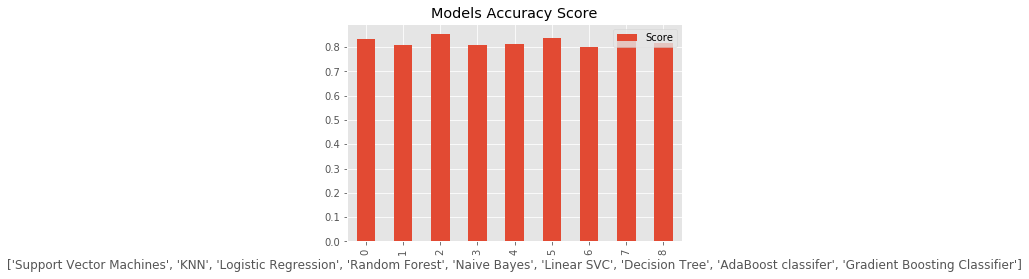

In [153]:
# 3.3 set up dataframe to see accuracy
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Linear SVC',
              'Decision Tree', 'AdaBoost classifer', 
              'Gradient Boosting Classifier'],
    'Score': [accuracy_score(SVC().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(KNeighborsClassifier().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(LogisticRegression().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(RandomForestClassifier().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(GaussianNB().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(LinearSVC().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(DecisionTreeClassifier().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(AdaBoostClassifier().fit(x_train,y_train).predict(x_test),y_test),
              accuracy_score(GradientBoostingClassifier().fit(x_train,y_train).predict(x_test),y_test),
              ]})
models.sort_values(by='Score', ascending=False)
print(models)
g = models.plot(kind = 'bar',title = 'Models Accuracy Score')
g.set_xlabel(list(models['Model']))


In [154]:
# 3.4 Increase the accuracy by using CV folders
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, 
                                        train_size = .6, random_state = 13)

# model will tested
mod = [SVC(),KNeighborsClassifier(),LogisticRegression(),RandomForestClassifier(),
       GaussianNB(),LinearSVC(),DecisionTreeClassifier(),AdaBoostClassifier(),
       GradientBoostingClassifier()]

# Cross validation
cv_train_score = list()
cv_test_score = list()
for model in mod :
    cv_result = cross_validate(model, train_data, train_Survived, cv  = cv_split)
    cv_train_score.append(cv_result['train_score'].mean())
    cv_test_score.append(cv_result['test_score'].mean())

cv_model = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
                  'Random Forest', 'Naive Bayes', 'Linear SVC',
                  'Decision Tree', 'AdaBoost classifer', 
                  'Gradient Boosting Classifier'],
        'CVTrainScore' :cv_train_score,
        'CVTestScore' : cv_test_score})
print(cv_model)

   CVTestScore  CVTrainScore                         Model
0     0.825000      0.834831       Support Vector Machines
1     0.800373      0.867603                           KNN
2     0.825000      0.850000           Logistic Regression
3     0.797388      0.951685                 Random Forest
4     0.771642      0.794007                   Naive Bayes
5     0.821642      0.845880                    Linear SVC
6     0.778731      0.963296                 Decision Tree
7     0.815672      0.855243            AdaBoost classifer
8     0.819776      0.916479  Gradient Boosting Classifier


In [20]:
# 3.5 Hyper parameters tunes
# I try to wirte a function for this tuning, but this seems to be a large 
# computation, so I try to tune each model by each
        # use estimator.get_params() to get params

# 3.5.1 SVC / Linear SVC
SVC().get_params()
param_grid = {'C':[1,10,100],
              'gamma': [0.01,0.001],
              'degree': [3,5,7],
              'kernel' :['rbf','linear'],
              'random_state' : [13]}
tuned_svc = GridSearchCV(SVC(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_svc.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_svc.best_params_)

Best Hyper Parameters:
 {'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'random_state': 13}


In [21]:
# 3.5.2 KNN
KNeighborsClassifier().get_params()
param_grid = {'n_neighbors':[3,5,7,9,11],
              'leaf_size':[1,2,3,5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto'],
              'n_jobs':[-1]}
tuned_knn = GridSearchCV(KNeighborsClassifier(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_knn.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_knn.best_params_)

Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 9, 'weights': 'uniform'}


In [22]:
# 3.5.3 Logistic Regression
LogisticRegression().get_params()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'max_iter': [25,50,100,200],
              'random_state': [13],
              'n_jobs': [-1]}
tuned_lr = GridSearchCV(LogisticRegression(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_lr.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_lr.best_params_)

Best Hyper Parameters:
 {'C': 1, 'max_iter': 25, 'n_jobs': -1, 'random_state': 13}


In [23]:
# 3.5.4 Random Forest
RandomForestClassifier().get_params()
param_grid = {'n_estimators': [10,100,300,500,800,1000],
              'max_features': ['auto'],
              'criterion' : ['gini','entropy'],
              'n_jobs' : [-1],
              'random_state' : [13]}
tuned_rf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_rf.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_rf.best_params_)


Best Hyper Parameters:
 {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 13}


In [24]:
# 3.5.5 Decision Tree
DecisionTreeClassifier().get_params()
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,10],
              'min_samples_split': [2,3,4,5,8],
              'min_samples_leaf': [1,2,3,5,8],
              'max_features': ['auto',None], 
              'random_state': [13]}
tuned_tree = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_tree.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_tree.best_params_)

Best Hyper Parameters:
 {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'random_state': 13}


In [25]:
# 3.5.6 AdaBoost classife
AdaBoostClassifier().get_params()
param_grid = {'n_estimators': [500,800,1000,1200],
              'learning_rate':[1,0.9],
              'algorithm' : ['SAMME', 'SAMME.R'],
              'random_state' : [13]}
tuned_ada = GridSearchCV(AdaBoostClassifier(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_ada.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_ada.best_params_)

Best Hyper Parameters:
 {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 1500, 'random_state': 13}


In [47]:
# 3.5.7 Gradient Boosting Classifier
GradientBoostingClassifier().get_params()
param_grid = {'learning_rate': [0.1],
              'min_samples_split':[2,5,8],
              'min_samples_leaf':[1],
              'max_depth':[3,7],
              'subsample':[.8],
              'n_estimators':[300,500],
              'random_state':[13]
              }
tuned_gbm = GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tuned_gbm.fit(train_data,train_Survived)
print("Best Hyper Parameters:\n",tuned_gbm.best_params_)

Best Hyper Parameters:
 {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 13, 'subsample': 0.8}


                                Model     Score
0  Support Vector Machines/Linear SVC  0.859236
1                                 KNN  0.852367
2                 Logistic Regression  0.863971
3                       Random Forest  0.852768
4                       Decision Tree  0.848822
5                  AdaBoost classifer  0.863679
6        Gradient Boosting Classifier  0.868139


Text(0.5,0,"['Support Vector Machines/Linear SVC', 'KNN', 'Logistic Regression', 'Random Forest', 'Decision Tree', 'AdaBoost classifer', 'Gradient Boosting Classifier']")

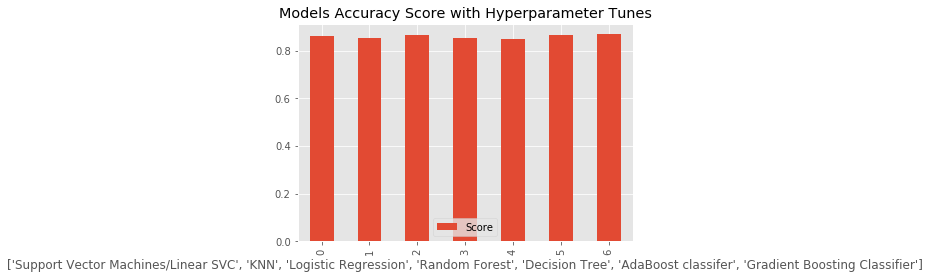

In [155]:
# 3.5.8 cv_result with Hyperparameter Tunes
cv_result = pd.DataFrame({
        'Model' : ['Support Vector Machines/Linear SVC', 'KNN', 'Logistic Regression',
                  'Random Forest', 'Decision Tree', 'AdaBoost classifer',                   
                  'Gradient Boosting Classifier'],
        'Score' : [tuned_svc.best_score_,tuned_knn.best_score_,tuned_lr.best_score_,
                   tuned_rf.best_score_,tuned_tree.best_score_,tuned_ada.best_score_,
                   tuned_gbm.best_score_]})
print(cv_result)
g = cv_result.plot(kind = 'bar',title = 'Models Accuracy Score with Hyperparameter Tunes')
g.set_xlabel(list(cv_result['Model']))

In [156]:
# 3.5.9 cv train / test score with parameter tunes
# model will tested
svm_mod = SVC(C = 100,degree = 3, gamma = .01, kernel = 'rbf',random_state = 13)
knn_mod = KNeighborsClassifier(leaf_size = 5,n_neighbors = 9,weights = 'uniform')
lr_mod = LogisticRegression(C= 1,max_iter = 25,random_state = 13)
rf_mod = RandomForestClassifier(criterion = 'entropy',n_estimators = 500,random_state = 13)
tree_mod = DecisionTreeClassifier(criterion = 'gini',max_depth = 4,min_samples_leaf = 3,
                                    min_samples_split = 8,random_state = 13)
ada_mod = AdaBoostClassifier(algorithm = 'SAMME',learning_rate = 1,n_estimators = 1500,
                                random_state = 13)
gbm_mod = GradientBoostingClassifier(learning_rate = .1,max_depth = 3,min_samples_leaf = 1,
                                     min_samples_split = 8,n_estimators = 300,
                                     random_state = 13,subsample = .8)

mod_tuned = [svm_mod,knn_mod,lr_mod,rf_mod,tree_mod,ada_mod,gbm_mod]

# Cross validation
cv_train_score_tuned = list()
cv_test_score_tuned = list()
for model in mod_tuned :
    cv_result = cross_validate(model, train_data, train_Survived, cv  = cv_split)
    cv_train_score_tuned.append(cv_result['train_score'].mean())
    cv_test_score_tuned.append(cv_result['test_score'].mean())

tuned_model = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
                  'Random Forest', 'Decision Tree', 'AdaBoost classifer', 
                  'Gradient Boosting Classifier'],
        'CVTrainScore' :cv_train_score_tuned,
        'CVTestScore' : cv_test_score_tuned})
print(tuned_model)

   CVTestScore  CVTrainScore                         Model
0     0.818657      0.854120       Support Vector Machines
1     0.811940      0.855243                           KNN
2     0.825000      0.850000           Logistic Regression
3     0.803358      0.963296                 Random Forest
4     0.817910      0.846816                 Decision Tree
5     0.819776      0.871348            AdaBoost classifer
6     0.822015      0.950375  Gradient Boosting Classifier


In [157]:
# 3.6 select the top 5 modeling for stacking
print('Select model : SVM, KNN, Logistic Regression,Gradient Boosting Classifier,Decision Tree')


Select model : SVM, KNN, Logistic Regression,Gradient Boosting Classifier,Decision Tree


In [158]:
# 3.7 Stacking dataset
# Predict the Survived from train by 5 different models, concatenate the predicted
# survived as new train dataset train_stacking. Same processing to the new test
# dataset test_stacking. train['Survived'] was set to the new train target as 
# train_Survived, and the final stacking model is XGBoosting
import random
train_index = random.sample(range(1,len(train)),round(0.6*len(train)))
test_index = random.sample(range(1,len(test)),round(0.6*len(test)))
train_stacking = np.concatenate(
        (svm_mod.fit(train_data.iloc[train_index],train_Survived.iloc[train_index]).predict(train_data).reshape(-1,1),
        knn_mod.fit(train_data.iloc[train_index],train_Survived.iloc[train_index]).predict(train_data).reshape(-1,1),
        lr_mod.fit(train_data.iloc[train_index],train_Survived.iloc[train_index]).predict(train_data).reshape(-1,1),
        tree_mod.fit(train_data.iloc[train_index],train_Survived.iloc[train_index]).predict(train_data).reshape(-1,1),
        gbm_mod.fit(train_data.iloc[train_index],train_Survived.iloc[train_index]).predict(train_data).reshape(-1,1)),
        axis = 1)
test_stacking = np.concatenate(
        (svm_mod.fit(train_data,train_Survived).predict(test).reshape(-1,1),
        knn_mod.fit(train_data,train_Survived).predict(test).reshape(-1,1),
        lr_mod.fit(train_data,train_Survived).predict(test).reshape(-1,1),
        tree_mod.fit(train_data,train_Survived).predict(test).reshape(-1,1),
        gbm_mod.fit(train_data,train_Survived).predict(test).reshape(-1,1)),
        axis = 1)
print(train_stacking.shape)
print(test_stacking.shape)
        


(891, 5)
(418, 5)


In [170]:
# 3.8 stacking modeling with xgb 
xgb_mod = xgb.XGBClassifier(
            #learning_rate = 0.02,
            n_estimators= 2000,
            max_depth= 4,
            min_child_weight= 2,
            gamma=0.9,
            subsample=0.8,
            colsample_bytree=0.8,
            objective= 'binary:logistic',
            nthread= -1,
            scale_pos_weight=1).fit(train_stacking, train_Survived)
predictions = xgb_mod.predict(test_stacking)

In [172]:
# 3.9 Submission File
Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
Submission.to_csv("Submission.csv", index=False)